In [2]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node

/home/soyeon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [4]:
experiment_dir = '/home/soyeon/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', 
               '16', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28']

# TR of functional images
with open('/home/soyeon/socialcomparison/task-socialcomparison_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing withds used during preprocessing
fwhm = [6]

In [5]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

In [6]:
import pandas as pd
trialinfo = pd.read_table('/home/soyeon/socialcomparison/task-socialcomparison_events.tsv')
trialinfo

,onset,duration,trial_type
0,0,20,fixation
1,20,14,fat_image
2,34,16,fixation
3,50,14,scramble_image
4,64,16,fixation
5,80,14,thin_image
6,94,16,fixation
7,110,14,scramble_image
8,124,16,fixation
9,140,14,fat_image


In [7]:
for group in trialinfo.groupby('trial_type'):
    print(group)
    print("")

('fat_image',     onset  duration trial_type
1      20        14  fat_image
9     140        14  fat_image
13    200        14  fat_image
19    300        14  fat_image
29    450        14  fat_image
35    540        14  fat_image)

('fixation',     onset  duration trial_type
0       0        20   fixation
2      34        16   fixation
4      64        16   fixation
6      94        16   fixation
8     124        16   fixation
10    154        16   fixation
12    184        16   fixation
14    214        16   fixation
16    244        16   fixation
18    284        16   fixation
20    314        16   fixation
22    344        16   fixation
24    374        16   fixation
26    404        16   fixation
28    434        16   fixation
30    464        16   fixation
32    494        16   fixation
34    524        16   fixation
36    560        20   fixation)

('scramble_image',     onset  duration      trial_type
3      50        14  scramble_image
7     110        14  scramble_image
11   

In [8]:
condition_names = ['fat_image', 'thin_image', 'scramble_image']

cont01 = ['average',        'T', condition_names, [1/3., 1/3., 1/3.]]
cont02 = ['fat',            'T', condition_names, [1, 0, 0]]
cont03 = ['thin',           'T', condition_names, [0, 1, 0]]
cont04 = ['control',        'T', condition_names, [0, 0, 1]]
cont05 = ['fat > control',  'T', condition_names, [1, 0, -1]]
cont06 = ['thin > control', 'T', condition_names, [0, 1, -1]]
cont07 = ['fat > thin',     'T', condition_names, [1, -1, 0]]

cont08 = ['activation',     'F', [cont02, cont03, cont04]]
cont09 = ['difference',     'F', [cont05, cont06, cont07]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09]

In [9]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    trialinfo = pd.read_table('/home/soyeon/socialcomparison/task-socialcomparison_events.tsv')
    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset)) 
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations,
                          #amplitudes=None,
                          #tmod=None,
                          #pmod=None,
                          #regressor_names=None,
                          #regressors=None
                         )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [10]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}',
                         'fwhm-{fwhm_id}_ssub-{subject_id}_task-{task_id}_bold.nii'),
             'mc_param': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}',
                             'sub-{subject_id}_task-{task_id}_bold.par'),
             'outliers': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}', 
                             'art.sub-{subject_id}_task-{task_id}_bold_outliers.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'socialcomparison'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s/fwhm-%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [11]:

# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

181028-20:53:57,699 nipype.workflow INFO:
	 Generated workflow graph: /home/soyeon/output/workingdir/l1analysis/graph.png (graph2use=colored, simple_form=True).


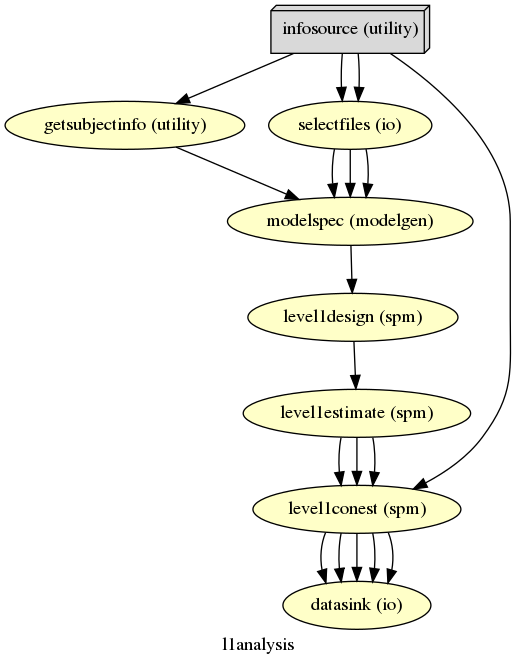

In [12]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.png'))

In [13]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

181028-20:53:58,653 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
181028-20:53:58,909 nipype.workflow INFO:
	 Running in parallel.
181028-20:53:58,917 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 52 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 4/4.
181028-20:53:58,994 nipype.workflow INFO:
	 [Job 1] Cached (l1analysis.getsubjectinfo).
181028-20:53:58,995 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/soyeon/output/workingdir/l1analysis/_fwhm_id_6_subject_id_28/selectfiles".
181028-20:53:59,7 nipype.workflow INFO:
	 [Job 8] Cached (l1analysis.getsubjectinfo).
181028-20:53:59,7 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
181028-20:53:59,20 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
181028-20:53:59,8 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/soyeon/output/workingdir/l1analy

In [22]:
from nilearn.plotting import plot_stat_map
anatimg = '/home/soyeon/output/datasink/preproc/sub-08/task-socialcomparison/sub-08_T1w_brain.nii.gz'

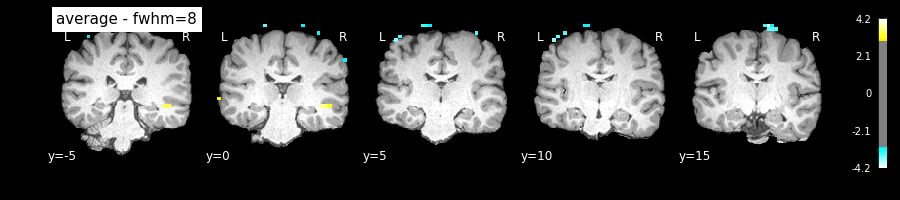

In [23]:
plot_stat_map(
    '/home/soyeon/output/datasink/1stLevel/sub-08/fwhm-6/spmT_0007.nii', title='average - fwhm=8',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

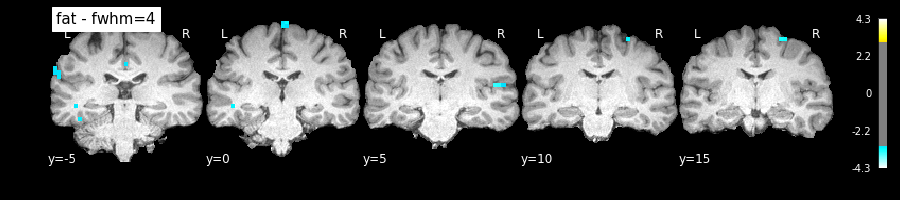

In [19]:
plot_stat_map(
    '/home/soyeon/output/datasink/1stLevel/sub-28/fwhm-6/spmT_0002.nii', title='fat - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

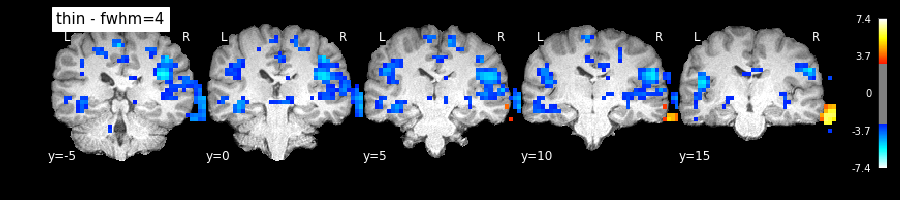

In [29]:
plot_stat_map(
    '/home/soyeon/output/datasink/1stLevel/sub-05/fwhm-6/spmT_0003.nii', title='thin - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

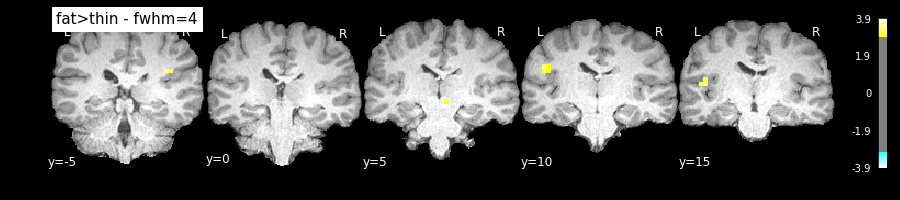

In [35]:
plot_stat_map(
    '/home/soyeon/output/datasink/1stLevel/sub-05/fwhm-6/spmT_0007.nii', title='fat>thin - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);